# [과제1] FCN
- 팀원: 박도현, 김윤희, 이지원

## 필요한 라이브러리 import

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

## 랜덤 시드 고정

- Random Seed를 고정하여 재현성을 보장한다.

In [ ]:
import random
import numpy as np

def set_random_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)

set_random_seed(1234)

## GPU 가용성 확인 및 연산 장치 결정

In [ ]:
print(f"CUDA Available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")

CUDA Available: True
Current Device: cuda


## Dataset Class 정의

- 파일이 없을 경우 자동으로 다운로드 수행

In [ ]:
# ====== 데이터 다운로드 ====== #
import os
import requests
import tarfile

def download_data(url, output_dir, file_name):
  os.makedirs(output_dir, exist_ok=True)
  file_path = os.path.join(output_dir, file_name)

  if not os.path.exists(file_path):
    print(f"Downloading {file_name} from {url}...")
    response = requests.get(url, stream=True)
    with open(file_path, 'wb') as f:
      for chunk in response.iter_content(chunk_size=1024):
        if chunk:
          f.write(chunk)
    print(f"Downloaded {file_name} to {file_path}")

  if file_path.endswith(".tar.gz"):
    print(f"Extracting {file_name}...")
    with tarfile.open(file_path, "r:gz") as tar:
      tar.extractall(path=output_dir)
    print(f"Extraction completed to {output_dir}")

url = "http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz"
output_dir = "./data"
file_name = "stl10_binary.tar.gz"

download_data(url, output_dir, file_name)

Downloaded stl10_binary.tar.gz to ./data/stl10_binary.tar.gz
Extracting stl10_binary.tar.gz...
Extraction completed to ./data


In [ ]:
# ====== 커스텀데이터셋 정의 ====== #
import os
import pandas as pd
import numpy as np
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import random_split, DataLoader

def read_images(file_path):
  with open(file_path, "rb") as f:
    images = np.fromfile(f, dtype=np.uint8)
    images = images.reshape(-1, 3, 96, 96)
  return images

def read_labels(file_path):
  with open(file_path, "rb") as f:
    labels = np.fromfile(f, dtype=np.uint8)
  return labels

transform=transforms.Compose([
  transforms.RandomRotation(degrees=10),
  transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
  transforms.ToTensor()
])

class STL10_Custom(Dataset):
  def __init__(self, image_file, label_file, transform=None, target_transform=None):
    self.images = read_images(image_file)
    self.labels = read_labels(label_file)
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx] - 1

    image = Image.fromarray(np.transpose(image, (1, 2, 0)))
    if self.transform:
      image = self.transform(image)

    if self.target_transform:
      label = self.target_transform(label)

    return image, label

In [ ]:
# ====== 데이터셋 정의 ====== #
train_dataset = STL10_Custom(
  image_file="./data/stl10_binary/train_X.bin",
  label_file="./data/stl10_binary/train_y.bin",
  transform=transform
)

train_dataset, validation_dataset = random_split(train_dataset, [4000, 1000])

test_dataset = STL10_Custom(
  image_file="./data/stl10_binary/test_X.bin",
  label_file="./data/stl10_binary/test_y.bin",
  transform=transforms.ToTensor()
)

## 데이터셋 준비

- train, validation 4:1 분할
- train 데이터셋에 Data Argumatation 적용

## MLP 모델 정의

- 3개의 층으로 구성
- 각 층마다 BatchNorm을 사용하여 정규화
- 각 층마다 Dropout을 사용하여 오버피팅 방지
- ReLU 활성화 함수를 사용
- Input Size: $96*96*3$
- Output Size: $10$

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()

    self.affine1 = nn.Linear(96 * 96 * 3, 1024)
    self.batchnorm1 = nn.BatchNorm1d(1024)
    self.dropout1 = nn.Dropout(0.5)

    self.affine2 = nn.Linear(1024, 64)
    self.batchnorm2 = nn.BatchNorm1d(64)
    self.dropout2 = nn.Dropout(0.5)

    self.affine3 = nn.Linear(64, 10)

    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.flatten(x)

    x = self.affine1(x)
    x = self.batchnorm1(x)
    x = self.activation(x)
    x = self.dropout1(x)

    x = self.affine2(x)
    x = self.batchnorm2(x)
    x = self.activation(x)
    x = self.dropout2(x)

    x = self.affine3(x)

    return x

## 학습 함수 정의

- 각 epoch마다 validation을 수행하여 성능 측정
- Early Stopping을 적용하여 일정 단위의 학습 동안 개선이 이루어지지 않는다면 조기 종료
- Validation Loss가 가장 낮았던 모델 상태를 저장하여 학습이 종료되는 시점에 반영

In [ ]:
def train(model, optimizer, loss_function, num_epochs, early_stop_patience, train_loader, validation_loader):
  min_validation_loss = None
  best_parameters = None
  early_stop_epoch_count = 0
  history = []

  for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss_temp = 0.0
    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)

      output = model(images)
      loss = loss_function(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss_temp += loss.item()

    training_loss = train_loss_temp / len(train_loader.dataset)

    # Validation
    model.eval()
    loss_temp = 0.0
    accuracy_temp = 0.0
    with torch.no_grad():
      for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        loss = loss_function(output, labels)

        prediction = output.argmax(dim=1)
        loss_temp += loss.item()
        accuracy_temp += torch.sum(prediction == labels)

    validation_loss = loss_temp / len(validation_loader.dataset)
    validation_accuracy = accuracy_temp.cpu() / len(validation_loader.dataset) * 100

    history.append((training_loss, validation_loss, validation_accuracy))

    print(f"[Epoch: {epoch + 1}] Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}%")

    if min_validation_loss is None or validation_loss < min_validation_loss:
      min_validation_loss = validation_loss
      best_parameters = model.state_dict()
      early_stop_epoch_count = 0
      print(f"[Epoch: {epoch + 1}] Min Validation Loss: {min_validation_loss}")
    else:
      early_stop_epoch_count += 1
      if early_stop_epoch_count == early_stop_patience:
        print(f"[Epoch: {epoch + 1}] Early Stop")
        break
      else:
        print(f"[Epoch: {epoch + 1}] No Improve")
    print("")

  model.load_state_dict(best_parameters)
  print(f"Best Parameters Loaded (Validation Loss: {min_validation_loss})")
  return history

## 학습 수행

- Learning Rate: 0.00001
- Optimizer: Adam
- Weight Decay: 0.00001
- Loss Function: CrossEntropyLoss
- Epochs: 200
- Early Stop Patience: 10
- Batch Size: 100

In [ ]:
model = MLP().to(device)

learning_rate = 0.00001

optimizer = torch.optim.Adam(
  model.parameters(),
  lr=learning_rate,
  weight_decay=0.00001
)

loss_function = nn.CrossEntropyLoss()

num_epochs = 200

early_stop_patience = 10

batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

In [ ]:
history = train(model, optimizer, loss_function, num_epochs, early_stop_patience, train_loader, validation_loader)

[Epoch: 1] Training Loss: 0.0231, Validation Loss: 0.0214, Validation Accuracy: 25.2000%
[Epoch: 1] Min Validation Loss: 0.02140704298019409

[Epoch: 2] Training Loss: 0.0217, Validation Loss: 0.0206, Validation Accuracy: 30.0000%
[Epoch: 2] Min Validation Loss: 0.020580883860588074

[Epoch: 3] Training Loss: 0.0212, Validation Loss: 0.0202, Validation Accuracy: 30.8000%
[Epoch: 3] Min Validation Loss: 0.02016938090324402

[Epoch: 4] Training Loss: 0.0209, Validation Loss: 0.0199, Validation Accuracy: 31.1000%
[Epoch: 4] Min Validation Loss: 0.01994019365310669

[Epoch: 5] Training Loss: 0.0206, Validation Loss: 0.0197, Validation Accuracy: 31.6000%
[Epoch: 5] Min Validation Loss: 0.019669352531433107

[Epoch: 6] Training Loss: 0.0204, Validation Loss: 0.0196, Validation Accuracy: 34.0000%
[Epoch: 6] Min Validation Loss: 0.019596624374389648

[Epoch: 7] Training Loss: 0.0203, Validation Loss: 0.0195, Validation Accuracy: 34.1000%
[Epoch: 7] Min Validation Loss: 0.01953998911380768

[Ep

## 학습 과정 시각화

In [ ]:
import matplotlib.pyplot as plt

def visualize(history):
  epochs = range(1, len(history) + 1)

  plt.figure(figsize=(18, 5))

  plt.subplot(1, 3, 1)
  plt.plot(epochs, tuple(item[0] for item in history), "r-", label="Training Loss")
  plt.plot(epochs, tuple(item[1] for item in history), "b-", label="Validation Loss")
  plt.title("Loss over Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.grid()

  plt.subplot(1, 3, 2)
  plt.plot(epochs, tuple(item[2] for item in history), "b-", label="Validation Accuracy")
  plt.title("Accuracy over Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.grid()

  plt.tight_layout()
  plt.show()

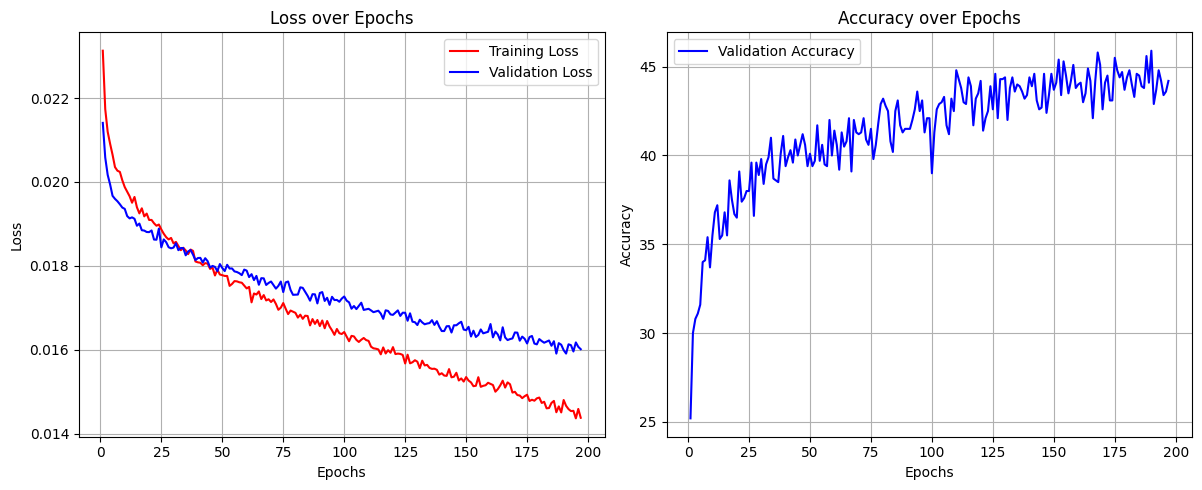

In [ ]:
visualize(history)

# 성능 측정

In [ ]:
def test(model, optimizer, loss_function, test_loader):
  # Test
  model.eval()
  loss_temp = 0.0
  accuracy_temp = 0.0
  with torch.no_grad():
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      output = model(images)
      loss = loss_function(output, labels)

      prediction = output.argmax(dim=1)
      loss_temp += loss.item()
      accuracy_temp += torch.sum(prediction == labels)

  test_loss = loss_temp / len(test_loader.dataset)
  test_accuracy = accuracy_temp.cpu() / len(test_loader.dataset) * 100

  print(f"Test Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.4f}%")

In [ ]:
test(model, optimizer, loss_function, test_loader)

Test Loss: 0.0154, 	Test Accuracy: 45.9375%


## 분석 및 고찰

- STL-10 특징
  - STL-10은 각 클래스에 500개의 라벨링된 학습 데이터만 제공되며, 이는 딥러닝 모델을 충분히 학습하기에 부족합니다.
  - STL-10의 큰 이미지 크기(96x96)는 FC Layer를 활용할 때 더 많은 파라미터를 필요로 하여 높은 연산비용으로 신경망의 차원, 깊이를 늘릴수록 연산량이 기하급수적으로 늘어날 수 있습니다.

- 추가한 점 (노력한 점)
  - earlystopping

    모델이 학습을 진행하는 도중, validation set의 성능이 더 이상 개선되지 않을 경우 학습을 조기에 멈추는 기법입니다.

    저희 code에서는 validation loss의 최적값을 기준으로 10 번 이상 갱신이 되지 않으면 멈추도록 하였습니다.
  - weight dacay

    손실함수에 weight에 대한 제곱항을 추가로 포함시키는 정규화 기법으로 모델이 가중치를 크게 학습시키는 것을 방지하고 더 일반화된 모델을 만들도록 유도하는 방법입니다.

    저희 code에서는 0.00001로 설정하였습니다.
  - dropout

    학습 과정에서 일부 뉴런을 무작위로 사용하지 않는 정규화 기법을 말합니다.

    저희는 dropout을 사용하지 않는 경우, 비율이 0.1, 0.2, 0.5 인 경우 총 4가지로 나누어 비교해보았습니다.

    - 사용하지 않은 경우
    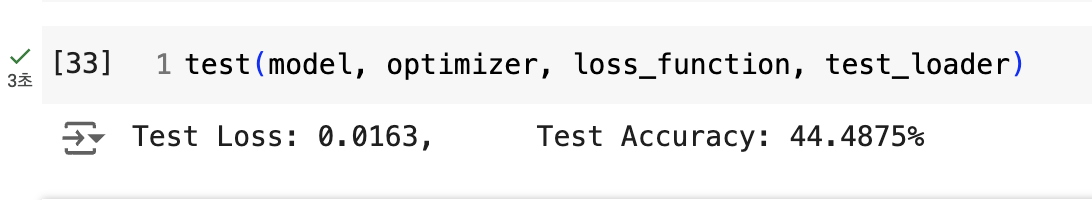

    - 비율이 0.2인 경우
    
    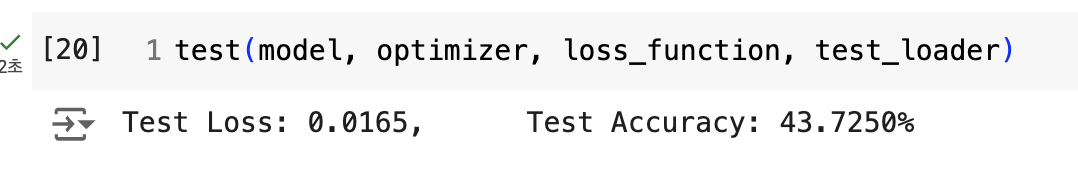

    - 비율이 0.5인 경우

    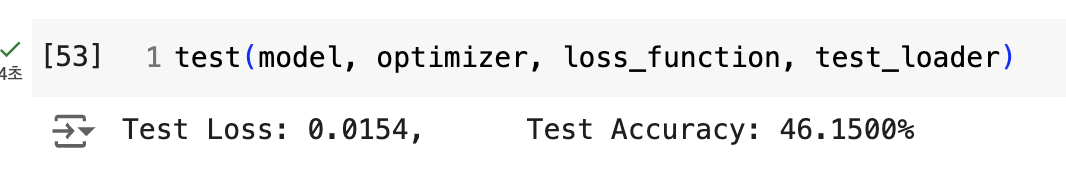

  dropout 비율이 0.5인 경우 성능이 가장 높은 것으로 나타났습니다.

  저희가 예상했을 때에는 0.5인 경우 데이터셋이 많지 않아 정보손실의 관점에서 가장 성능이 낮을 것이라고 생각하였는데,
  Dropout으로 인해 각 네트워크의 subset이 각각 다른 형태로 학습되게 되면서 전체적인 bagging 효과를 불러올 수 있었고, 결국 overfitting에 더욱 robust한 학습이 이루어지면서 test 성능이 높게 나타난 것으로 확인할 수 있었습니다.





  


- 한계점  
  - fcn 모델 자체가 이미지의 구조적 특징을 파악하기엔 한계가 있어 전체적으로 accuracy가 높은 수치를 띄지 않습니다.
  - 또한 train data 개수가 상당히 적어 일반적인 특징을 학습하기에 한계가 있고, overfitting될 가능성이 높습니다.
  - 여러 시도를 해보았지만, fcn 모델이 학습하는 과정 자체에서 존재하는 단점을 극적으로 해결할 수는 없었습니다.